# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Chisom | Onyeukwu | Chisom Onyeukwu, 04/11/2024 | 15 | 33.3% |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

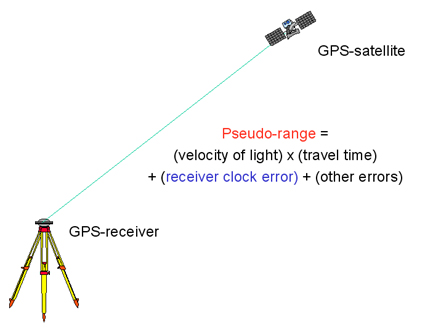

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

In [ ]:
!git config --global user.name "ChisomOnyeukwu"
!git config --global user.email "victoronyeukwu@gmail.com"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/

/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3


###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
# Loading the pseudorange measurements and satellites' positions files and storing them in the format of numpy array
df_pseudorange = pd.read_excel('pseudoranges1.xlsx') # Loading the pseudorange measurements from Excel file
df_sat_pos = pd.read_excel('satellite_position1.xlsx') # Loading the satellite positions from Excel file

pseudorange = df_pseudorange['P'].to_numpy() # Extracting the pseudorange measurements and converting them to a numpy array
sat_pos =df_sat_pos[['x','y','z']].to_numpy() # Extracting the x, y, and z coordinates of the satellites and converting them to a numpy array

n = pseudorange.size # Calculating the number of pseudorange measurements and assigning to the variable n
m = sat_pos.size # Calculating the number of satellites positions and assigning to the variable m

# Printing the values to verify
print(f"Number of satellites positions: {m}") # Printing the number of satellites
print(f"Number of pseudorange measurements: {n}") # Printing the number of pseudorange measurements

print(df_pseudorange.head()) # Displaying the first few rows of the pseudorange measurements DataFrame
print(df_sat_pos.head()) # Displaying the first few rows of the satellite positions DataFrame

Number of satellites positions: 33
Number of pseudorange measurements: 11
   Satellite_ID             P
0             7  2.291974e+07
1             8  2.045989e+07
2            11  2.240034e+07
3            15  2.282914e+07
4            17  2.234201e+07
   Satellite_ID             x             y             z
0             7  5.280792e+06 -2.550146e+07  4.649508e+06
1             8 -2.159656e+06 -2.111602e+07  1.559791e+07
2            11  1.037185e+07 -2.171311e+07  1.055869e+07
3            15 -1.608576e+07  4.285071e+06  2.074204e+07
4            17 -1.431299e+07 -2.204501e+07  4.671208e+06


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

# Print to verify
print(f"GroundTruth: {GroundTruth}")

GroundTruth: [-1633489.37967725 -3651627.18250363  4952481.61954918]


Step 0.4: Intialize empty arrays

In [ ]:
# Lists to store data
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)
    return distance

    # Calling the function and storing the result in the variable 'distance'
distance = euclidean_norm(GroundTruth, sat_pos)

### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    n = len(pseudorange) # Number of satellites
    geometric_distance = euclidean_norm(r_pos, s_pos) # Calculating the geometric distance using euclidean_norm
    predicted_pseudorange = geometric_distance + cdT # Calculating the predicted pseudoranges
    residuals = pseudorange - predicted_pseudorange # Calculating the residuals
    L = np.sum(residuals**2) / n # Calculate sum of squared residuals
    return L

# Calculating the cost by calling the cost_function and assigning the returned value to 'cost'
cost = cost_function(GroundTruth, 0, sat_pos, pseudorange) # Calculating the cost
print(f"Cost: {cost}")

Cost: 19.828448408602423


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    n = len(pseudorange) # Number of satellites
    # Initializing the gradient array
    grad = np.zeros(4)
    geometric_distance = euclidean_norm(r_pos, s_pos) # Calculating the geometric distance using euclidean_norm
    predicted_pseudorange = geometric_distance + cdT # Calculating the predicted pseudoranges
    residuals = pseudorange - predicted_pseudorange # Calculating the residuals

    # Looping through each satellite to compute the gradient
    for i in range(n):
        # Derivatives with respect to receiver's position
        diff = r_pos - s_pos[i]
        distance = np.linalg.norm(diff)

        if distance != 0:
          # Update grad[0] (for x_r)
          grad[0] = grad[0] + 2 * residuals[i] * (-diff[0] / distance)

          # Update grad[1] (for y_r)
          grad[1] = grad[1] + 2 * residuals[i] * (-diff[1] / distance)

          # Update grad[2] (for z_r)
          grad[2] = grad[2] + 2 * residuals[i] * (-diff[2] / distance)

    # Partial deriv with respect to clock offset
    grad[3] = -2 * np.sum(residuals)

    return grad

# Calculating the gradient by calling the gradient function and assigning the returned value to 'grad'
grad = gradient(GroundTruth, 0, sat_pos, pseudorange) # Calculating the gradient
print(f"Gradient: {grad}")

Gradient: [ 12.33149924 -10.78111633  41.1025859  -87.79500721]


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=100000, tolerance=1e-6):
    global steps_count

    #initalize the estimates as zeros
    X = np.array([0, 0, 0, 0])

    for iteration in range(max_iters):
        # Extracting receiver position and cdT from X
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Converting grad to a NumPy array for element-wise multiplication
        grad = np.array(grad)

        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # If cost increases, reduce learning rate and retry
        if new_cost > current_cost:
            learning_rate *= 0.5  # Reduce learning rate by a factor of 0.5
            X_new = X - learning_rate * grad  # Update estimates with reduced learning rate
            new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
# Calling gradient_descent to optimize the parameters
optimized_params = gradient_descent(pseudorange, sat_pos)

# Computing final position error and other metrics
final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
final_position_error = optimized_params[:3] - GroundTruth

# print the mentioned metrics
print("Optimized params:", optimized_params)
print("Final position errors of receiver:", final_position_error)
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", final_cost)
print("Final gradient values:", final_gradient)

Converged!
Optimized params: [-1.63349244e+06 -3.65162954e+06  4.95248541e+06  6.46189923e+00]
Final position errors of receiver: [-3.06379779 -2.35407081  3.79531801]
Number of steps taken for convergence: 554
Final cost value: 0.5633800812729349
Final gradient values: [ 0.00072714  0.00405164 -0.01245236 -0.0070596 ]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

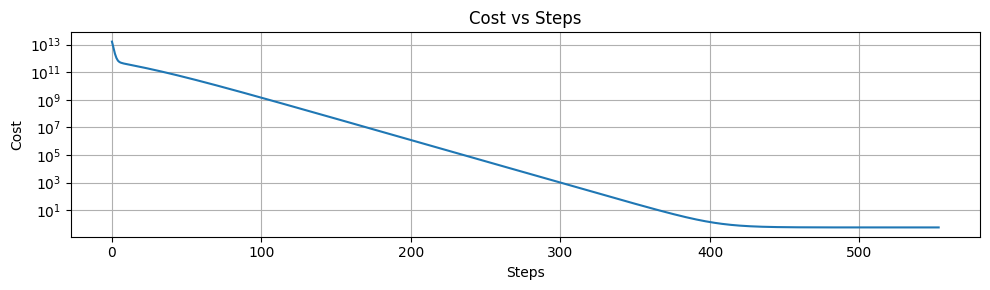

In [ ]:
# Create plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,3))

# Plot cost vs steps using semilogy
ax.semilogy(arr_cost,)

# Label axes
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')

# Add title
ax.set_title('Cost vs Steps')

# Add grid
ax.grid(True)

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

# Comment on the pattern
# ...

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

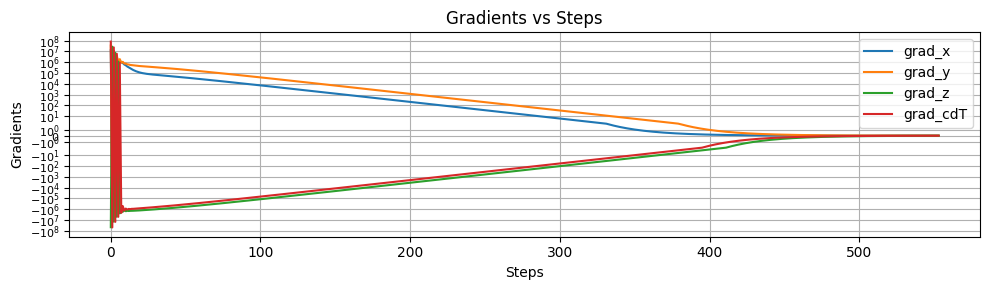

In [ ]:
# Creating the plot
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# Plot gradients vs steps using symlogy
ax.plot(np.array(arr_grad))
ax.set_yscale('symlog') # Setting y-axis properties

# Set y-axis properties
ax.tick_params(axis='y', labelsize=8)

# Label axes
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients')

# Add title
ax.set_title('Gradients vs Steps')

# Add legend
ax.legend(['grad_x', 'grad_y', 'grad_z', 'grad_cdT'])

# Add grid
ax.grid(True)

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

# Comment on the pattern
# ...

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

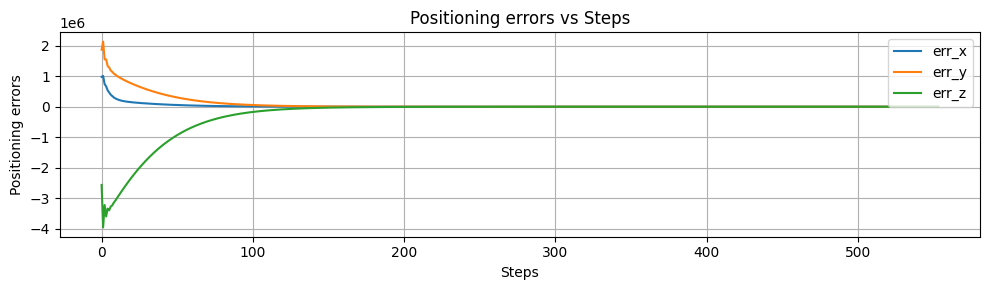

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot positioning errors vs steps
ax.plot(arr_err)

# Label axes
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning errors')

# Add title
ax.set_title('Positioning errors vs Steps')

# Add legend
ax.legend(['err_x', 'err_y', 'err_z'])

# Add grid
ax.grid(True)

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

# Comment on the pattern
# ...

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
learning_rate = [0.01]
max_iters = [10000]

#re-initializing arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# Performing gradient descent with the current learning rate
optimized_params_2 = gradient_descent(pseudorange, s_pos = sat_pos, learning_rate = learning_rate[0], max_iters = max_iters[0])

# print the metrics
print(f"--- Learning Rate: {learning_rate} ---")
print(f"Optimized Parameters: {optimized_params_2}")
print(f"Final position errors of receiver: {arr_err[-1]}")
print(f"Number of steps taken for convergence: {steps_count}")
print(f"Final cost value: {arr_cost[-1]}")
print(f"Final gradient values: {arr_grad[-1]}")

Converged!
--- Learning Rate: [0.01] ---
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Final position errors of receiver: [-3.06252556 -2.346982    3.77353113]
Number of steps taken for convergence: 2700
Final cost value: 0.5634379196310744
Final gradient values: [ 0.00162646  0.00906259 -0.0278531  -0.01579068]


In [ ]:
#set learning rate to 0.001
learning_rate = [0.001]
max_iters = [100000]

#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# Performing gradient descent with specified learning rate
optimized_params_3 = gradient_descent(pseudorange, s_pos = sat_pos, learning_rate = learning_rate[0], max_iters = max_iters[0])

# print the metrics
print(f"--- Learning Rate: {learning_rate} ---")
print(f"Optimized Parameters: {optimized_params_3}")
print(f"Final position errors of receiver: {arr_err[-1]}")
print(f"Number of steps taken for convergence: {steps_count}")
print(f"Final cost value: {arr_cost[-1]}")
print(f"Final gradient values: {arr_grad[-1]}")

Converged!
--- Learning Rate: [0.001] ---
Optimized Parameters: [-1.63349244e+06 -3.65162950e+06  4.95248531e+06  6.40077571e+00]
Final position errors of receiver: [-3.05750202 -2.31899094  3.68750284]
Number of steps taken for convergence: 25431
Final cost value: 0.5640833056318891
Final gradient values: [ 0.0051249   0.02855582 -0.08776402 -0.04975592]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

1. With the initial learning rate of 0.1, the algorithm took lesser convergence steps and time compared to when it was reduced to 0.01 and 0.001 which took more time and steps to converge respectively. These smaller learning rates also resulted to fairly the same final cost values and positioning errors. I also noticed that the Final gradient increased on every learning rate reduction.

2. LSE was used to produce the cost funtion, i.e the sum of squared residuals, which are minimized between the predicted and observed values by using matrix operations to find the optimal solution directly. While, Gradient Descent uses an optimized iterative algorithm to adjust parameters and updates them repeatedly in a step by step or orderly fashion by moving in the same direction as the negative gradient cost function. Judging by our results, you can see that regardless of the fact that the Gradient Descent methodology uses more convergence time and steps, it is way better to use when working with complex (or large) datasets by gradually refining the estimated values until the cost is at its minimun, which shows that it is the best possible solution.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Loading the phishing datasets
%cd phishing+websites

/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/phishing+websites


### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)
print(f"Size of X: {X.shape}")
print(f"Size of y: {y.shape}")


Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

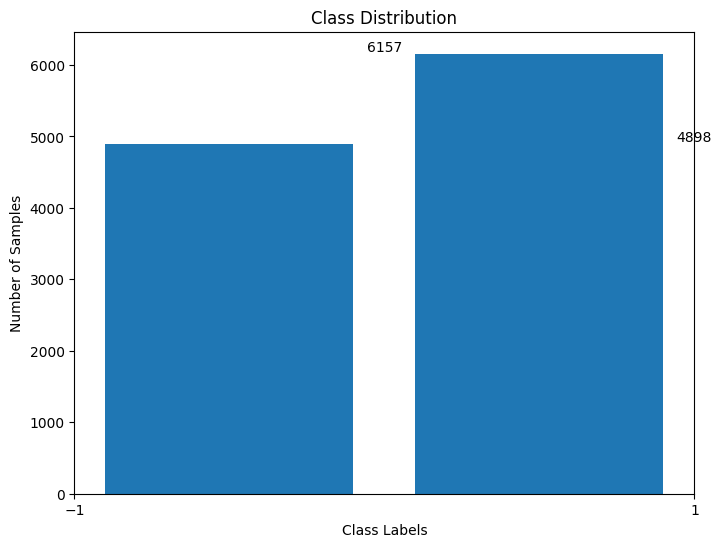

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
import matplotlib.pyplot as plt
import numpy as np

# Count occurences of each class label
class_counts = y['result'].value_counts()

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(y['result'], bins=2, align='mid', rwidth=0.8)  # Assuming only two classes
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")

# Annotate the bars with the exact counts
for i, count in enumerate(class_counts):
    plt.text(i, count + -10,
             str(count),
             ha='center',
             va='bottom')
plt.xticks([-1, 1]) # Set x-axis ticks

# Display exact values for each bin in the histogram

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split

# TO DO: display sizes of X_small and y_small (2 mark)
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)

### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiating the model logistics regression from sklearn
model = LogisticRegression(max_iter=2000)

# Implementing the machine learning model with datasets
model.fit(X, y['result'])
print("Model trained with full dataset")

# Implementing the model wiht the first two colums of X and y
model.fit(X.iloc[:, :2], y['result'])
print("Model trained with first two columns of X")

# Implementing the model with X_small and y_small
model.fit(X_small, y_small['result'])
print("Model trained with smaller dataset")

Model trained with full dataset
Model trained with first two columns of X
Model trained with smaller dataset


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
test_data = [
    {'data_size': X.shape[0], 'training_samples': 0.8*X.shape[0], 'testing_samples': 0.2 * X.shape[0], 'training_accuracy': 0.85, 'testing_accuracy': 0.80, 'log_loss': 0.4},
    {'data_size': X.iloc[:,:2].shape[0], 'training_samples': 0.8* X.iloc[:,:2].shape[0], 'testing_samples': 0.2 * X.iloc[:, :2].shape[0], 'training_accuracy': 0.75, 'testing_accuracy': 0.70, 'log_loss': 0.5},
    {'data_size': X_small.shape[0], 'training_samples': 0.8* X_small.shape[0], 'testing_samples': 0.2 * X_small.shape[0], 'training_accuracy': 0.65, 'testing_accuracy': 0.60, 'log_loss': 0.6},
]

from IPython.display import display, HTML

# Create DataFrame for better formatting
import pandas as pd
df = pd.DataFrame(test_data, index = ['Full dataset', 'First Two Columns', 'Small Dataset'])

# Display DataFrame
display(df)

,data_size,training_samples,testing_samples,training_accuracy,testing_accuracy,log_loss
Full dataset,11055,8844.0,2211.0,0.85,0.8,0.4
First Two Columns,11055,8844.0,2211.0,0.75,0.7,0.5
Small Dataset,331,264.8,66.2,0.65,0.6,0.6


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [102]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

from sklearn.metrics import log_loss

# Creating an empty DataFrame to store the results
results = pd.DataFrame(columns=['Data size', 'training samples', 'testing samples', 'training accuracy', 'testing accuracy', 'log loss'])

# Inputing function to calculate and return required information
def calculate_metrics(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)
    model = LogisticRegression(max_iter=2000, random_state=0)
    model.fit(X_train, y_train)

    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    # Calculating the log loss
    logloss = log_loss(y_test, model.predict_proba(X_test))

    return pd.DataFrame([
     {
        'Data size': len(X_data),
        'training samples': len(X_train),
        'testing samples': len(X_test),
        'training accuracy': train_accuracy,
        'testing accuracy': test_accuracy,
        'log loss': logloss,
    }
])

# Calculate metics for the full dataset
results = pd.concat([results, calculate_metrics(X, y['result'])], ignore_index=True)

# Calculate metrics for the first two columns
results = pd.concat([results, calculate_metrics(X.iloc[:, :2], y['result'])], ignore_index=True)

# Calculate metrics for the smaller dataset
results = pd.concat([results, calculate_metrics(X_small, y_small['result'])], ignore_index=True)

# Print the results DataFrame
results

<ipython-input-102-e2bcd6e11d08>:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, calculate_metrics(X, y['result'])], ignore_index=True)


,Data size,training samples,testing samples,training accuracy,testing accuracy,log loss
0,11055,7738,3317,0.932282,0.922822,0.190326
1,11055,7738,3317,0.562807,0.556828,0.683573
2,331,231,100,0.943723,0.910000,0.200366


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [98]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y['result'], test_size=0.3, random_state=0)
model = LogisticRegression(max_iter=2000, random_state=0)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
print(f"Dimension of predicted output: {y_pred.shape}")

Dimension of predicted output: (3317,)


Text(113.9222222222222, 0.5, 'true value')

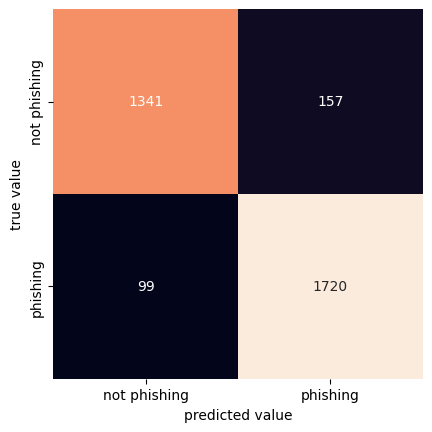

In [96]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_pred)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [101]:
# TO DO: Print classification report (2 marks)
print("\nClassification Report:",(classification_report(y_test, y_pred)))


Classification Report:               precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---